# STAT5243 Project 4: Causal Inference

***Group 2:***

    Wendy Doan
    Yibai Liu
    Yiwen Fang
    Shuqi Yu
    Zhihang Xia

## Introduction

In this project, we studied **Causal Inference** on two datasets, one high-dimensional and another low-dimensional. 

Specifically, we estimated the **Average Treatment Effects (ATE)** by calculating the **Propensity Scores (PS)** using the **Boosting Stumps** algorithm. 

The ATEs are then calculated using three models and compared with the true values to estimate accuracy. For each algorithm and method,  The performance and computational efficiency were evaluated for each dataset to select the best combination. 

Propensity Scores: (Boosting Stumps)
1. GBM 
2. XGboost

ATE Estimation Methods:
1. Stratification
2. Regression Adjustment
3. Stratification + Regression Adjustment 

To aid with propensity score prediction, we also attempted to alleviate the slight imbalance in the data through well known methods such as oversampling and SMOTE.

## Propensity Score Estimation

We define the propensity score as:

$$e(x) = Pr(T =1|X=x)$$

The propensity score is given in term of probability 

$$0<e(x)<1$$


##  Step 0: Import packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set a random seed for reproduction.
RANDOM_STATE = np.random.seed(42)

# train-test split for propensity score
from sklearn.model_selection import train_test_split

# baseline propensity score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# grid search
from sklearn.model_selection import GridSearchCV

# propensity score from tree models
import xgboost as xgb
from xgboost import XGBClassifier

# GBM
from sklearn.ensemble import GradientBoostingClassifier

# Stratification and Regression Adjustment
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression

# Imbalance techniques
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.under_sampling import NearMiss

## Step 1: Import and explore data

To increase the usability of the notebook, we use generic variable names instead of associating with the datasets used in for the project. To use the notebook with other datasets, simply import with variable name `dataset`

We have two dataset, `High Dimensional Dataset` and `Low Dimensional Dataset`

The goal of this project is estimating the ATE of two dataset: high and low dimensional. 

In [3]:
# Set up your directory for the datasets
directory = "../"

In [4]:
highDim_dataset = pd.read_csv(directory + 'data/highDim_dataset.csv')
lowDim_dataset = pd.read_csv(directory + 'data/lowDim_dataset.csv')

In [5]:
high_true_ATE = -54.8558
low_true_ATE = 2.0901

In [6]:
##############################################################################
##############################################################################
# Choose a development option between highDim_dataset and lowDim_dataset

dataset = lowDim_dataset.copy()
dataset_name = "Low-Dimensional Dataset"
true_ATE = low_true_ATE

#dataset = highDim_dataset.copy()
#dataset_name = "High-Dimensional Dataset"
#true_ATE = high_true_ATE

In [7]:
dataset.head()

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
0,30.486999,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,9.09,1.149622
1,18.208417,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,1.40,...,0.7,0.00,1.40,0.0,1.40,0.0,0.00,0.00,0.00,2.887702
2,13.485040,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,3.57,0.0,0.00,0.0,0.00,0.00,0.00,0.000000
3,25.699678,1,2.38,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,2.38,0.0,2.38,0.0,0.00,0.00,0.00,0.405465
4,23.752968,0,0.15,0.15,0.05,0.1,0.0,0.42,0.1,0.95,...,0.0,0.36,3.16,0.0,1.58,0.0,0.52,0.31,0.00,1.574639


The high-dimensional dataset has 2000 observations of 187 dimensions, while the low-dimensional dataset has 500 observations of 24 dimensions.

It is convenient to extract only the X portion, which is columns other than Y (treatment result) and A (binary treatment/control group)

In [8]:
data_X = dataset.drop(['Y', 'A'], axis=1).copy()

In [9]:
data_X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,9.09,1.149622
1,0.00,0.00,0.00,0.0,0.0,0.00,0.0,1.40,0.00,0.00,...,0.7,0.00,1.40,0.0,1.40,0.0,0.00,0.00,0.00,2.887702
2,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,0.0,0.00,3.57,0.0,0.00,0.0,0.00,0.00,0.00,0.000000
3,2.38,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,0.0,0.00,2.38,0.0,2.38,0.0,0.00,0.00,0.00,0.405465
4,0.15,0.15,0.05,0.1,0.0,0.42,0.1,0.95,0.42,0.05,...,0.0,0.36,3.16,0.0,1.58,0.0,0.52,0.31,0.00,1.574639


In [10]:
def plotComposition(dataset, reset_index=False):
    plt.plot(dataset[dataset.A == 1].Y.reset_index(drop=True) 
             if reset_index 
             else dataset[dataset.A == 1].Y, 'o', label='Treatment')
    plt.plot(dataset[dataset.A == 0].Y.reset_index(drop=True) 
             if reset_index 
             else dataset[dataset.A == 0].Y, 'ro', label='Control')
    plt.title(dataset_name + " Distribution")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

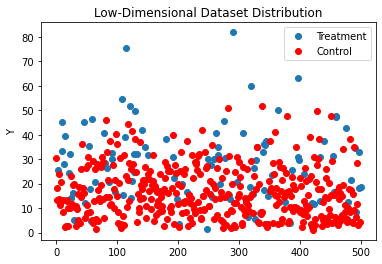

In [11]:
plotComposition(dataset)

## Step 2: Naive estimate of ATE

Check the origianl ATE for both high and low dimension data without any steps and algorithms

In [12]:
def naive_ATE(dataset):
    return np.average(dataset[dataset.A == 1].Y) - np.average(dataset[dataset.A == 0].Y)

In [13]:
print("Naive ATE for high-dimensional data:", naive_ATE(highDim_dataset))
print("Naive ATE for low-dimensional data:", naive_ATE(lowDim_dataset))

Naive ATE for high-dimensional data: -75.17133436876799
Naive ATE for low-dimensional data: 10.602068661915688


## Step 3: Data preprocessing


### Are the data sets balanced?

In [14]:
def checkComposition(dataset):
    print("The dataset contains:\n",len(dataset[dataset.A == 1]), "cases in Treatment group\n", 
          len(dataset[dataset.A == 0]), "cases in Control group.")
    print("Treatment/Control ratio: {}/100".format(round(len(dataset[dataset.A == 1])/len(dataset[dataset.A == 0])*100)))

In [15]:
print("High-dimensional")
checkComposition(highDim_dataset)
print('-'*20)
print("Low-dimensional")
checkComposition(lowDim_dataset)

High-dimensional
The dataset contains:
 643 cases in Treatment group
 1357 cases in Control group.
Treatment/Control ratio: 47/100
--------------------
Low-dimensional
The dataset contains:
 106 cases in Treatment group
 394 cases in Control group.
Treatment/Control ratio: 27/100


In this case, the high-dimensional data is slightly imbalanced, but acceptable. However, the low-dimensional data displays severer imbalance between groups. In any cases, one can use oversampling or smote to balance the data, which however may not be beneficial for some ATE estimation algorithms. 

### Oversampling to deal with the imbalanced data

Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. We used oversampling the minority instead of undersampling the majority since undersampling removes instances from data that may be carrying important information.


1. **Random Oversampling**: 

To randomly replicate the small sample to match the size of the larger sample.

2. **SMOTE**: Synthetic Minority Oversampling Technique

SMOTE generates synthetic samples from the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.



In [16]:
def Oversample(dataset):
    ovs = RandomOverSampler(random_state = RANDOM_STATE)
    x, y = ovs.fit_resample(dataset.loc[:, dataset.columns != 'A'], dataset.A)
    x.insert(1, 'A', y)
    return x

The dataset contains:
 394 cases in Treatment group
 394 cases in Control group.
Treatment/Control ratio: 100/100


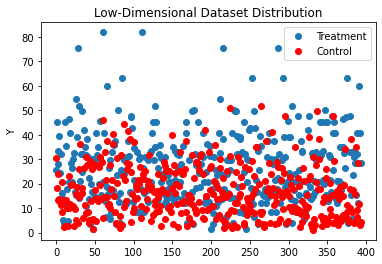

In [17]:
dataset_oversampled = Oversample(dataset)

checkComposition(dataset_oversampled)
plotComposition(dataset_oversampled, reset_index=True)

In [18]:
def SMOTE(dataset):
    smk = SMOTETomek()
    x, y = smk.fit_resample(dataset.loc[:, dataset.columns != 'A'], dataset.A)
    x.insert(1, 'A', y)
    return x

The dataset contains:
 384 cases in Treatment group
 384 cases in Control group.
Treatment/Control ratio: 100/100


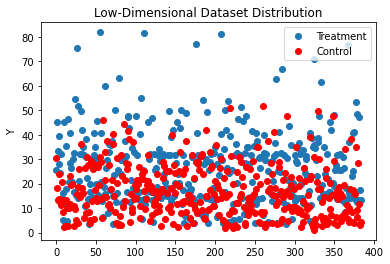

In [19]:
dataset_smote = SMOTE(dataset)

checkComposition(dataset_smote)
plotComposition(dataset_smote, reset_index=True)

In summary, there are three dataset that can be used: orginial, oversampled, and SMOTE. For testing purpose, change the variable splitted in the beginning of the next section, instead of pasting them all into one notebook. 

## Step 4: Calculating the propensity score

The propensity score is estimated by applying machine learning methods on the `X` variable to fit the label `A`. For this purpose (and this purpose only) the dataset is splitted into train and test set. 

### Split into train and test set

We split the dataset into train and test with the porpotion of 20:80. We will use the train data to train the model and do the cross validation to avoid overfitting. Then use the test data to check our model

In [20]:
def split_train_test(dataset, test_size=0.2):
    X = np.array(dataset.drop(['Y', 'A'], axis=1))
    y = np.array(dataset.Y)
    A = np.array(dataset.A)
    
    idx_train, idx_test, y_train, y_test = train_test_split(range(X.shape[0]), y, test_size=0.2, random_state=RANDOM_STATE)
    X_train = X[idx_train]
    X_test = X[idx_test]
    A_train = A[idx_train]
    A_test = A[idx_test]
    return X_train, X_test, y_train, y_test, A_train, A_test

Update dataset name HERE to test the original, oversampled, SMOTE, or any new dataset. 

In [21]:
##############################################################################
##############################################################################
# Development choices include dataset, dataset_oversampled and dataset_smote

X_train, X_test, y_train, y_test, A_train, A_test = split_train_test(dataset)

### Propensity Score - Boosted Stumps

In this notebook we use GBM and XGboost. For any choices of learner, it is desirable to perform cross validation and grid search for the best model. We then evaluate the model prediction on the test set. 

#### Gradient Boosting

In [22]:
param_grid = {
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [2, 3, 5],
              'min_samples_split': [2, 4],
              'n_estimators': [5, 10, 15, 20],
              'min_samples_leaf':[1, 3, 5]
              }

In [23]:
def grid_search(X:np.array, A:np.array, model, param_grid=param_grid, cv=10, print_step = True, sample_weight=None):
    """
    Takes a baseline model and does grid search among parameters in the param_grid with cross validation.
    Returns the model with best hyparameters after searching
    """
    if sample_weight is None:
        clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1, scoring = 'roc_auc').fit(X, A)
    else:
        clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1, scoring = 'roc_auc').fit(X, A, sample_weight = sample_weight)
    print("Best accuracy: %0.3f" % (clf.best_score_))
    print()
    print("Best parameters: %r" % clf.best_params_)
    print('-'*30)
    if print_step:
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print('-'*30)

    return(model.set_params(**clf.best_params_))

Running the cross validation takes a few minutes. Uncomment this cell for developement. 

In [24]:
# gbm = grid_search(
#     X_train, A_train, model=GradientBoostingClassifier(random_state=RANDOM_STATE), 
#     param_grid=param_grid,
#     print_step=True)

A copy of best hyperparameters from grid search

In [25]:
best_params = {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_samples_split': 4, 'n_estimators': 20}

In [26]:
gbm = GradientBoostingClassifier(random_state=RANDOM_STATE).set_params(**best_params).fit(X_train, A_train)

In [27]:
print(gbm.score(X_train, A_train))
print(gbm.score(X_test, A_test))

0.8975
0.81


In [28]:
# Predict propensity scores
propensity_score_gbm = np.exp(gbm.predict_log_proba(dataset.iloc[:, 2:]))[:, 1]

#### Weighted XGBoost

In [29]:
param_grid_xgb = {
    'objective':['binary:logistic', 'reg:squarederror'],
    'n_estimators':[5, 10, 15, 20],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1.0, 1.5],
    'subsample': [0.3, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8],
    'max_depth': [3, 4]
    #'scale_pos_weight':[1, 2, 4]
}

Running the cross validation takes a few minutes. Uncomment this cell for developement. 

In [30]:
# xgb = grid_search(X_train, A_train, 
#             model=XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE),
#             param_grid = param_grid_xgb, 
#             print_step=True, 
#             cv=5
#            )           

A copy of best hyperparameters from grid search

In [31]:
best_params_xgb = {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 4, 
                   'min_child_weight': 1, 'n_estimators': 20,     
                   'objective': 'reg:squarederror', 'subsample': 1.0}

xgb = XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE).set_params(**best_params_xgb).fit(X_train, A_train)

In [32]:
print(xgb.score(X_train, A_train))
print(xgb.score(X_test, A_test))

0.8775
0.8


In [33]:
# Predict propensity scores
propensity_score_xgb = xgb.predict_proba(np.array(dataset.iloc[:, 2:]))[:, 1]

To summarize, we have obtained the propensity scores using GBM and XGBoost. These can now be used to calculate the ATE score. 

## Step 5: Extract relevant data for ATE calculation

It is convenient to attach the newly constructed propensity score with `A` and `Y`. For the stratification, this is all required. However for regression method, `X` is also required to remove further confounding factors. 

In [34]:
def combine_data(ps, A, y):
    """
    Combines propensity scores with A and y
    
    Returns a data frame with three columns
    """
    data_combined = pd.DataFrame(
        np.array([ps, A, y]).T,
        columns=['e', 'A', 'Y']
    )
    return data_combined

We summarized the selected models in the following pipleine

In [96]:
def data_preparation_pipeline(dataset, resample=None, label=dataset_name, boost='GBM'):
    """
    Each sampling method results in a different data size, a set of best 
    hyperparameters from grid search, and an array of sample weights. 
    This pipeline prepares a dataset, with the specified resampling method, 
    for the later ATE estimation.
    """
    test_scores = []
    params = []
    weights =[]

    if resample == None:
        data = dataset
    elif resample == 'over':
        data = Oversample(dataset)
    elif resample == 'smote':
        data = SMOTE(dataset)
    else:
        print("Error: Invalid resampling method! Possible options include None, 'over' and 'smote'")
        
    # Predict with GBM
    if boost=='GBM':    
        # A copy of the best hyperparameter candidates from grid search:
        if label == 'Low-Dimensional Dataset':
            gbm_params0 = {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 
                         'min_samples_split': 4, 'n_estimators': 20}
            gbm_params1 =  {'learning_rate': 0.05, 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
            gbm_params2 = {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
        elif label == "High-Dimensional Dataset":
            gbm_params0 = {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
            gbm_params1 =  {'learning_rate': 0.05, 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
            gbm_params2 = {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
        else:
            print("Error: Invalid resampling method! Possible options include None, 'over' and 'smote'")
        #best_params3 = {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
        #best_params4 = {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
        params_list = [gbm_params0, gbm_params1, gbm_params2]#, best_params3, best_params4]
        
        X_train, X_test, y_train, y_test, A_train, A_test = split_train_test(data)
        
        for i in range(15,22):
            # high-dimensional weights (the best weights after multiple trials)
            sample_weights = np.zeros(len(A_train))
            sample_weights[A_train == 0] = i
            sample_weights[A_train == 1] = 20
            
            for p in params_list:
                gbm = GradientBoostingClassifier().set_params(**p).fit(X_train, A_train,sample_weight=sample_weights)
                #print(gbm.score(X_train, A_train), gbm.score(X_test, A_test))
                test_scores.append(gbm.score(X_test, A_test))
                params.append(p)
                weights.append(sample_weights)
            
        best_ = params[test_scores.index(max(test_scores))]
        gbm = GradientBoostingClassifier().set_params(**best_).fit(X_train, A_train,
                                                                   sample_weight=weights[test_scores.index(max(test_scores))])
        print("Train accuracy: ",gbm.score(X_train, A_train))
        print("Test accuracy: ", gbm.score(X_test, A_test))
        propensity_score_gbm = np.exp(gbm.predict_log_proba(data.iloc[:, 2:]))[:, 1]
    
        ps_data = combine_data(propensity_score_gbm, data.A, data.Y)
    
    # Predict with XGB
    elif boost=='XGB':
        best_params_xgb = {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 4, 
                   'min_child_weight': 1, 'n_estimators': 20,     
                   'objective': 'reg:squarederror', 'subsample': 1.0}

        xgb = XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE).set_params(**best_params_xgb).fit(X_train, A_train)
        print("XGboost train accuracy: ",xgb.score(X_train, A_train))
        print("XGboost test accuracy: ", xgb.score(X_test, A_test))
        propensity_score_xgb = xgb.predict_proba(np.array(dataset.iloc[:, 2:]))[:, 1]
        ps_data = combine_data(propensity_score_xgb, data.A, data.Y)
        
    else:
        print("Error: Wrong boosting methods! Possible options include 'GBM' and 'XGB'")
        
    X_data = data.drop(['Y', 'A'], axis=1)
    return ps_data, X_data


## Step 6: Calculating ATE with different algorithms

### ATE Estimate - Stratification


A common approach to estimate ATE using stratification based on propensity scores.

$$ 
∆ˆS = \sum_{j=1}^{k}(N_j / N)\{N^{−1}_{1j} \sum_{i=1}^{N} T_i*Y_i*I(e_i ∈ Q_j ) − N^{−1}_{0j}*\sum^{N}_{i=1}(1 − T_i)Y_i*I(e_i ∈ Q_j ) 
$$

where K is the number of strata, some literature have advocate to use quintiles (K=5). 
$Nj$ is the number of individuals in stratum j. $N_{1j}$ is the number of “treated” individuals in stratum `j`, while $N_{0j}$ is the number of “controlled” individuals in stratum `j`. $$Q_j = (q_{j−1}, q_{j}] $$ where $q_j$ is the jth sample quantile of the estimated
propensity scores. (See Lunceford and Davidian (2004))

In [36]:
def Stratify(ps_data:pd.DataFrame, k:int):
    
    data_copy = ps_data.copy()
    
    # rank to resolve duplicate edge cases
    data_copy['bin'] = pd.qcut(
        data_copy.e.rank(method='first'), k, labels=False
    )
    
    return data_copy

In [37]:
def Calculate_ATE_Strat(ps_data:pd.DataFrame, k:int):
    
    n = ps_data.shape[0]
    
    data_copy = Stratify(ps_data, k)
    
    # calculate ATE score
    ATE = 0
    for k_idx in range(k):
        
        # temporary data frame
        Qj = data_copy[data_copy.bin == k_idx]
        nj = Qj.shape[0]

        treat_avg = np.average(Qj[Qj.A==1].Y) if Qj[Qj.A==1].shape[0] != 0 else 0
        control_avg = np.average(Qj[Qj.A==0].Y) if Qj[Qj.A==0].shape[0] != 0 else 0
        ATE += (nj/n) * ( treat_avg - control_avg )
    
    return ATE

### ATE Estimate - Regression and Stratification + Regression Adjustment

With regression adjustment, data for each bin is further corrected using regression on `X`, with level variable `A`. 

Note that setting k = 1 bin is equivalent to performing only regression estimation. 


In [38]:
def Calculate_ATE_StratRegrAdjusted_with_X(data:pd.DataFrame, X_data, k:int):
    
    n = data.shape[0]
    
    data_adjusted = pd.concat(
        [Stratify(data, k), X_data.reset_index(drop=True)], axis=1)
    
    # calculate ATE score
    ATE = 0
    for k_idx in range(k):
        
        # temporary data frame
        Qj = data_adjusted[data_adjusted.bin == k_idx]
        nj = Qj.shape[0]
 
        # Regression Adjusted Linearly, then Delta_j = alpha^Z_j
        X = Qj.drop(['e', 'Y', 'bin'], axis=1)
        y = Qj.Y
        reg = LinearRegression().fit(X, y)
        
        ATE += reg.coef_[0]
        
    return ATE / k

## Result summary

In [58]:
summary_cols=["Model", "Data", "PS model", "Estimation time(s)","Squared error"]
summary = pd.DataFrame(columns=summary_cols)

In [57]:
row3= pd.DataFrame([[str('Strat'), str('oi'), 'GBM', 
                         1, round((1 - 1.111)**2,4)]], columns = summary_cols)
summary = summary.append(row3)

In [59]:
def estimation_summary(data:pd.DataFrame, data_X:pd.DataFrame, max_k:int, true_ATE=true_ATE, title="high", resample=None):
    """
    This function reads in data and returns best ATE estimation generated from the 
    most appropriate k value for each algorithm.
    
    inputs
    -------
    data: pd.DataFrame, columns are (e, Y, A)
    data_X: pd.DataFrame, the set of X variables
    max_k: int, the maximum k value used to calculate ATE
    true_ATE: float, the true ATE score used to plot against estimations
    title: str, a string used to label high/low-dimensional datasets in the plot. Possible values are "high" or "low"
    
    outputs
    -------
    strat: float, best ATE estimate by stratification
    regadj: float, best ATE estimate by regression adjustment
    combined: float, best ATE estimate by stratification + regression adjustment
    log: pd.DataFrame, chunk of summary table
    
    """
    strat_results = [Calculate_ATE_Strat(data, i) for i in range(1, max_k+1)]
    strat_reg_results = [Calculate_ATE_StratRegrAdjusted_with_X(data, data_X, i) for i in range(1, max_k+1)]
    
    error = [abs(strat_results[i] - true_ATE) for i in range(len(strat_results))]
    best_k_strat = error.index(min(error))
    #best_ATE_strat = strat_results[best_k_strat]
    
    error = [abs(strat_reg_results[i] - true_ATE) for i in range(len(strat_reg_results))]
    best_k_strat_reg = error.index(min(error))
    #best_ATE_strat_reg = strat_reg_results[best_k_strat_reg]
    
    start = time.time()
    strat = Calculate_ATE_Strat(data, best_k_strat)
    t_strat = time.time()-start
    print("Time for calculating ATE with stratification: {}s".format(round(t_strat, 4)))
    
    start = time.time()
    regadj = Calculate_ATE_StratRegrAdjusted_with_X(data, data_X, 1)
    t_regadj = time.time()-start
    print("Time for calculating ATE with regression adjustment: {}s".format(round(t_regadj, 4)))
    
    start = time.time()
    combined = Calculate_ATE_StratRegrAdjusted_with_X(data, data_X, best_k_strat_reg)
    t_combined = time.time()-start
    print("Time for calculating ATE with stratification + regression adjustment: {}s".format(round(t_combined, 4)))
    
    print("Estimated ATE by stratification with k = {}: {}".format(best_k_strat+1, strat))
    print("Estimated ATE by regression adjustment: {}".format(regadj))
    print("Estimated ATE by stratification + regression adjustment with k = {}: {}".format(best_k_strat_reg+1, combined))
    
    # Add results to summary
    log = pd.DataFrame(columns=summary_cols)
    resample_str = resample if resample != None else ''
    row1= pd.DataFrame([[str('Stratification (K={})'.format(best_k_strat+1)), str(title+'-dim'+resample_str), 'GBM', 
                         t_strat, round((strat-true_ATE)**2,4)]], columns = summary_cols)
    log = log.append(row1)
    row2= pd.DataFrame([['Regression Adjustment', str(title+'-dim'+resample_str), 'GBM', 
                         t_regadj, round((regadj - true_ATE)**2,4)]], columns = summary_cols)
    log = log.append(row2)
    row3= pd.DataFrame([[str('Strat. + Reg. Adj. (K={})'.format(best_k_strat_reg+1)), str(title+'-dim'+resample_str), 'GBM', 
                         t_combined, round((combined - true_ATE)**2,4)]], columns = summary_cols)
    log = log.append(row3)
    
    
    # Plot: 
    plt.figure(figsize=(10,6))
    plt.plot(range(1,max_k+1), strat_results, marker='o',
                label = 'ATE estimate by stratification')
    plt.plot(range(1,max_k+1), strat_reg_results, marker='o',
                label = 'ATE estimate by strat + reg_adj')
    plt.scatter(1, regadj, s=150, label='ATE estimate by regression adjustment',alpha=1, marker='o',c='green')

    plt.hlines(true_ATE, 1, 10, colors='red', linestyles='dashed', label='ATE true')
    #plt.hlines(naive_ATE(data), 1, 10, colors='grey', linestyles='dashed', label='ATE Naive')
    plt.title("The {}-dimensional dataset\nTrue ATE vs. Estimated ATE".format(title))
    plt.xlabel("Number of strata (k)")
    plt.ylabel("ATE")
    plt.legend()
    plt.show()
    
    return strat, regadj, combined, log

### High dimensional dataset

In [48]:
dataset = highDim_dataset.copy()
dataset_name = "High-Dimensional Dataset"
true_ATE = high_true_ATE

Train accuracy:  0.743125
Test accuracy:  0.72
Time for calculating ATE with stratification: 0.01s
Time for calculating ATE with regression adjustment: 0.025s
Time for calculating ATE with stratification + regression adjustment: 0.035s
Estimated ATE by stratification with k = 5: -55.45518853439334
Estimated ATE by regression adjustment: -59.365443691851674
Estimated ATE by stratification + regression adjustment with k = 3: -55.6714004280003


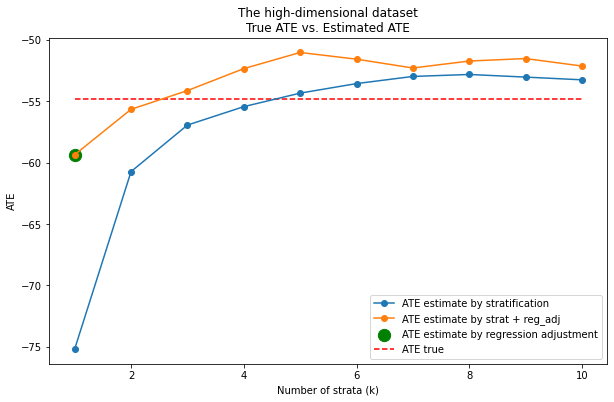

In [60]:
data_for_ATE, X_data = data_preparation_pipeline(dataset, resample=None, label=dataset_name)
strat, regadj, combined, log = estimation_summary(data_for_ATE, X_data, max_k=10, true_ATE=true_ATE, 
                                                  title="high", resample=None)
summary = summary.append(log)

Train accuracy:  0.9474896361123906
Test accuracy:  0.7697974217311234
Time for calculating ATE with stratification: 0.019s
Time for calculating ATE with regression adjustment: 0.033s
Time for calculating ATE with stratification + regression adjustment: 0.039s
Estimated ATE by stratification with k = 8: -53.20953890728808
Estimated ATE by regression adjustment: -59.4221983041025
Estimated ATE by stratification + regression adjustment with k = 3: -53.38779108748621


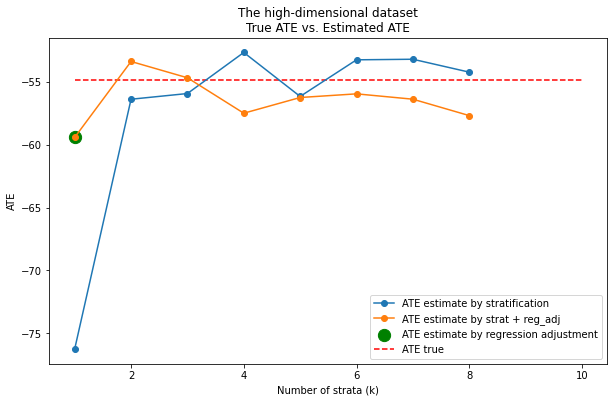

In [62]:
data_for_ATE, X_data = data_preparation_pipeline(dataset, resample='over', label=dataset_name)
strat_ovr, regadj_ovr, combined_ovr, log = estimation_summary(data_for_ATE, X_data, max_k=8, true_ATE=true_ATE, 
                                                              title="high", resample='(oversampled)')
summary = summary.append(log)

Train accuracy:  0.9657437822618489
Test accuracy:  0.7936210131332082
Time for calculating ATE with stratification: 0.007s
Time for calculating ATE with regression adjustment: 0.052s
Time for calculating ATE with stratification + regression adjustment: 0.056s
Estimated ATE by stratification with k = 2: -73.50714563475833
Estimated ATE by regression adjustment: -57.24814374092138
Estimated ATE by stratification + regression adjustment with k = 3: -59.01337892549398


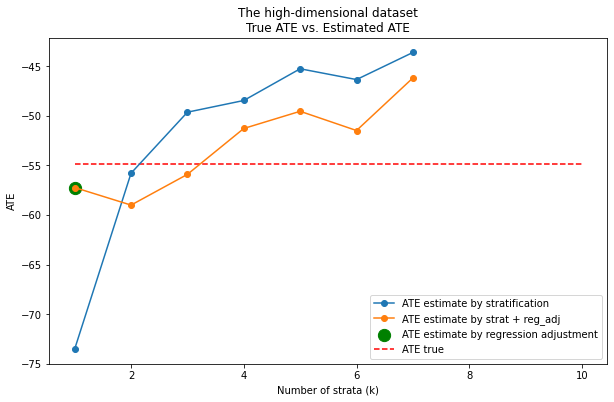

In [63]:
data_for_ATE, X_data = data_preparation_pipeline(dataset, resample='smote', label=dataset_name)
strat_smt, regadj_smt, combined_smt, log = estimation_summary(data_for_ATE, X_data, max_k=7, true_ATE=true_ATE, 
                                                         title="high", resample='(SMOTE)')
summary = summary.append(log)

**Note: The ATE estimates would suddenly get far off when we increased the number of strata further, so here we only plot reasonable K values.**

### Low dimensional dataset

In [65]:
dataset = lowDim_dataset.copy()
dataset_name = "Low-Dimensional Dataset"
true_ATE = low_true_ATE

Train accuracy:  0.875
Test accuracy:  0.78
Time for calculating ATE with stratification: 0.006s
Time for calculating ATE with regression adjustment: 0.005s
Time for calculating ATE with stratification + regression adjustment: 0.017s
Estimated ATE by stratification with k = 4: 3.010356881708587
Estimated ATE by regression adjustment: 2.472655707042314
Estimated ATE by stratification + regression adjustment with k = 8: 2.056348929413826


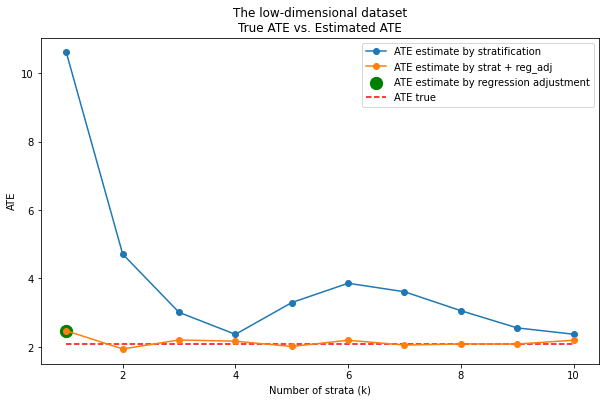

In [66]:
data_for_ATE, X_data = data_preparation_pipeline(dataset, resample=None, label=dataset_name)
strat, regadj, combined,log = estimation_summary(data_for_ATE, X_data, max_k=10, true_ATE=true_ATE, 
                                                 title="low", resample=None)
summary = summary.append(log)

Train accuracy:  0.9698412698412698
Test accuracy:  0.8734177215189873
Time for calculating ATE with stratification: 0.015s
Time for calculating ATE with regression adjustment: 0.005s
Time for calculating ATE with stratification + regression adjustment: 0.024s
Estimated ATE by stratification with k = 7: -8.083107628211868
Estimated ATE by regression adjustment: 2.3358788019507717
Estimated ATE by stratification + regression adjustment with k = 10: 1.8177414082721528


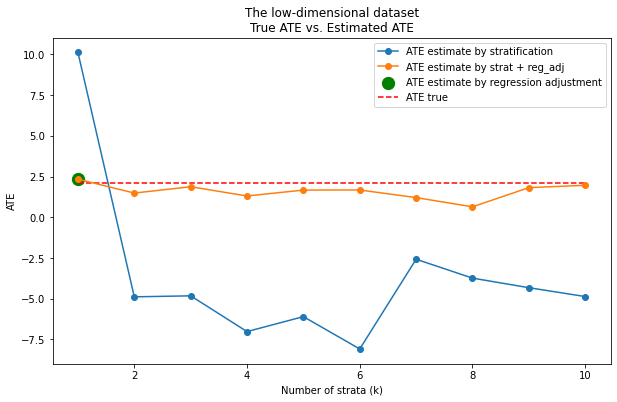

In [68]:
data_for_ATE, X_data = data_preparation_pipeline(dataset, resample='over', label=dataset_name)
strat, regadj, combined,log = estimation_summary(data_for_ATE, X_data, max_k=10, true_ATE=true_ATE, 
                                                 title="low", resample='(oversampled)')
summary = summary.append(log)

Train accuracy:  0.9837133550488599
Test accuracy:  0.8116883116883117
Time for calculating ATE with stratification: 0.01s
Time for calculating ATE with regression adjustment: 0.005s
Time for calculating ATE with stratification + regression adjustment: 0.005s
Estimated ATE by stratification with k = 5: 5.148730432227882
Estimated ATE by regression adjustment: 2.3849368617933897
Estimated ATE by stratification + regression adjustment with k = 2: 2.3849368617933897


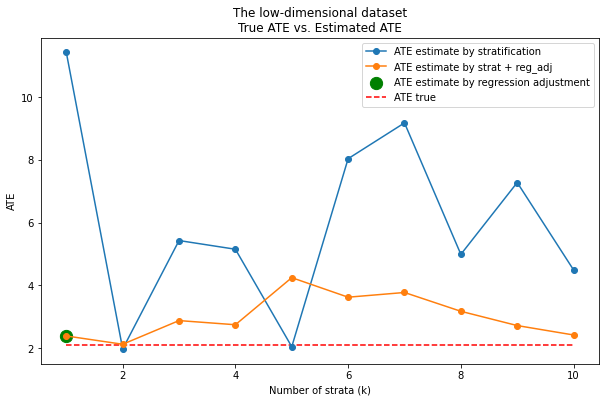

In [69]:
data_for_ATE, X_data = data_preparation_pipeline(dataset, resample='smote', label=dataset_name)
strat, regadj, combined, log = estimation_summary(data_for_ATE, X_data, max_k=10, true_ATE=true_ATE, 
                                             title="low", resample='(SMOTE)')
summary = summary.append(log)

In [90]:
summary = summary.reset_index().drop(['index'], axis=1)
summary.to_csv('../output/summary.csv', index=False)

,Model,Data,PS model,Estimation time(s),Squared error
0,Stratification (K=5),high-dim,GBM,0.010000,0.3593
1,Regression Adjustment,high-dim,GBM,0.025001,20.3369
2,Strat. + Reg. Adj. (K=3),high-dim,GBM,0.035000,0.6652
3,Stratification (K=8),high-dim(oversampled),GBM,0.018966,2.7102
4,Regression Adjustment,high-dim(oversampled),GBM,0.033000,20.8520
5,Strat. + Reg. Adj. (K=3),high-dim(oversampled),GBM,0.039000,2.1551
6,Stratification (K=2),high-dim(SMOTE),GBM,0.007003,347.8727
7,Regression Adjustment,high-dim(SMOTE),GBM,0.051961,5.7233
8,Strat. + Reg. Adj. (K=3),high-dim(SMOTE),GBM,0.056000,17.2855
9,Stratification (K=4),low-dim,GBM,0.006000,0.8469


## Conclusion and recommendations

Among three algorithms, both **stratification** and **stratification with regression adjustment** are flexible which enable us to choose a specified k that fits the dataset better, whereas **regression adjustment** is fixed and less flexible.

Considering the estimation accuracy, for the low-dimensional dataset, **stratification with regression adjustment** gets the most accurate estimate. For the high-dimensional dataset, **stratification** achieves the best ATE estimate closest to the true ATE by setting k = 5

For time complexity, **stratification with regression adjustment** is generally the lowest when estimating ATE. **Regression adjustment** works the fastest when the dataset has low dimensions, but when the dataset increases in its dimensionality, **Regression adjustment** slows down and **stratification** becomes faster.

We also discussed the effects of resampling on the model performance, ......................not finished (not obvious improvements cuz gbm itself is quite robust to imbalanced datasets?)

Finally, as our recommendations, .........................................not finished

In [94]:
summary = pd.read_csv('../output/summary.csv')
# Sort by estimation accuracy
summary.sort_values(by=['Squared error', 'Estimation time(s)'])

,Model,Data,PS model,Estimation time(s),Squared error
11,Strat. + Reg. Adj. (K=8),low-dim,GBM,0.017000,0.0011
13,Regression Adjustment,low-dim(oversampled),GBM,0.005000,0.0604
14,Strat. + Reg. Adj. (K=10),low-dim(oversampled),GBM,0.024001,0.0742
17,Strat. + Reg. Adj. (K=2),low-dim(SMOTE),GBM,0.004999,0.0869
16,Regression Adjustment,low-dim(SMOTE),GBM,0.005002,0.0869
10,Regression Adjustment,low-dim,GBM,0.005000,0.1463
0,Stratification (K=5),high-dim,GBM,0.010000,0.3593
2,Strat. + Reg. Adj. (K=3),high-dim,GBM,0.035000,0.6652
9,Stratification (K=4),low-dim,GBM,0.006000,0.8469
5,Strat. + Reg. Adj. (K=3),high-dim(oversampled),GBM,0.039000,2.1551


In [95]:
# Sort by time complexity
summary.sort_values(by=['Estimation time(s)'])

,Model,Data,PS model,Estimation time(s),Squared error
17,Strat. + Reg. Adj. (K=2),low-dim(SMOTE),GBM,0.004999,0.0869
10,Regression Adjustment,low-dim,GBM,0.005000,0.1463
13,Regression Adjustment,low-dim(oversampled),GBM,0.005000,0.0604
16,Regression Adjustment,low-dim(SMOTE),GBM,0.005002,0.0869
9,Stratification (K=4),low-dim,GBM,0.006000,0.8469
6,Stratification (K=2),high-dim(SMOTE),GBM,0.007003,347.8727
15,Stratification (K=5),low-dim(SMOTE),GBM,0.009999,9.3552
0,Stratification (K=5),high-dim,GBM,0.010000,0.3593
12,Stratification (K=7),low-dim(oversampled),GBM,0.014997,103.4942
11,Strat. + Reg. Adj. (K=8),low-dim,GBM,0.017000,0.0011


## References


1. Chan, D., Ge, R., Gershony, O., Hesterberg, T. and Lambert, D., 2010, July. Evaluating online ad campaigns in a pipeline: causal models at scale. In Proceedings of the 16th ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 7-16). https://doi.org/10.1145/1835804.1835809

2. D'Agostino Jr, R.B., 1998. Propensity score methods for bias reduction in the comparison of a treatment to a non‐randomized control group. Statistics in medicine, 17(19), pp.2265-2281. https://doi.org/10.1002/(SICI)1097-0258(19981015)17:19%3C2265::AID-SIM918%3E3.0.CO;2-B

3. Hirano, K. and Imbens, G.W., 2001. Estimation of causal effects using propensity score weighting: An application to data on right heart catheterization. Health Services and Outcomes research methodology, 2(3), pp.259-278. https://doi.org/10.1023/A:1020371312283

4. Austin, P.C., 2011. An introduction to propensity score methods for reducing the effects of confounding in observational studies. Multivariate behavioral research, 46(3), pp.399-424. https://dx.doi.org/10.1080%2F00273171.2011.568786

5. Stuart, E.A., 2009. Matching methods for causal inference: A review and a look forward. Baltimore, MD: Johns Hopkins Bloomberg School of Public Health. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2943670/

6. Lunceford, J.K., 2017. Stratification and weighting via the propensity score in estimation of causal treatment effects: a comparative study. Statistics in medicine, 36(14), pp.2320-2320. https://doi.org/10.1002/sim.1903

7. Overcoming Class Imbalance using SMOTE Techniques, https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/#:~:text=SMOTE%20is%20an%20oversampling%20technique%20where%20the%20synthetic,interpolation%20between%20the%20positive%20instances%20that%20lie%20together.

8. Github Page of Applied Data Science https://github.com/TZstatsADS/ADS_Teaching/blob/master/Projects_StarterCodes/Project4-CausalInference/doc/project4_desc.md
